# |In this notebook we fit a SEIR model to the Moscow Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.seir import SEIR, DayAheadFitter, CurveFitter
from sir_models.utils import stepwise
from sir_models.utils import eval_one_day_ahead

# Load data

In [6]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

# Model

In [76]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [77]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [87]:
model = SEIR(stepwise_size=60)
fitter = CurveFitter(use_recovered=False)
fitter.fit(model, train_subset)

Iter 0 | MAE: 3665.8021
Iter 10 | MAE: 995.9851
Iter 20 | MAE: 775.4282
Iter 30 | MAE: 769.1024
Iter 40 | MAE: 679.8703
Iter 50 | MAE: 671.4064
Iter 60 | MAE: 653.7739
Iter 70 | MAE: 511.5153
Iter 80 | MAE: 481.0236
Iter 90 | MAE: 439.8265
Iter 100 | MAE: 430.2623
Iter 110 | MAE: 417.7423
Iter 120 | MAE: 413.3899
Iter 130 | MAE: 408.7093
Iter 140 | MAE: 408.6675
Iter 150 | MAE: 407.4784
Iter 160 | MAE: 404.3525
Iter 170 | MAE: 403.8356
Iter 180 | MAE: 402.5954
Iter 190 | MAE: 401.4918
Iter 200 | MAE: 398.8300
Iter 210 | MAE: 399.0067
Iter 220 | MAE: 398.4885
Iter 230 | MAE: 398.2481
Iter 240 | MAE: 398.2098
Iter 250 | MAE: 398.0912
Iter 260 | MAE: 398.0921


In [88]:
result = fitter.result
result

In [89]:
train_initial_conditions = fitter.get_initial_conditions(model, train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)

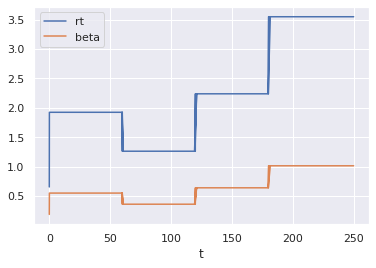

In [90]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

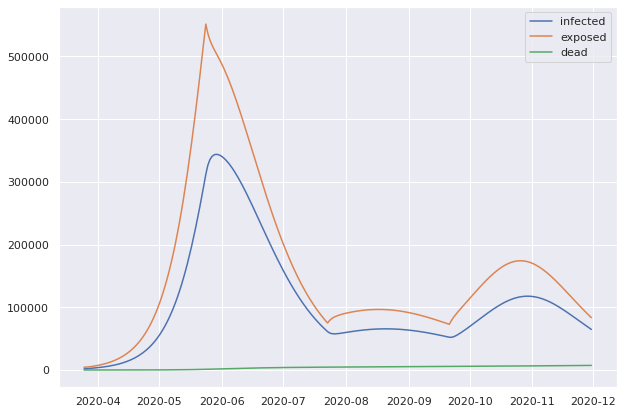

In [91]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

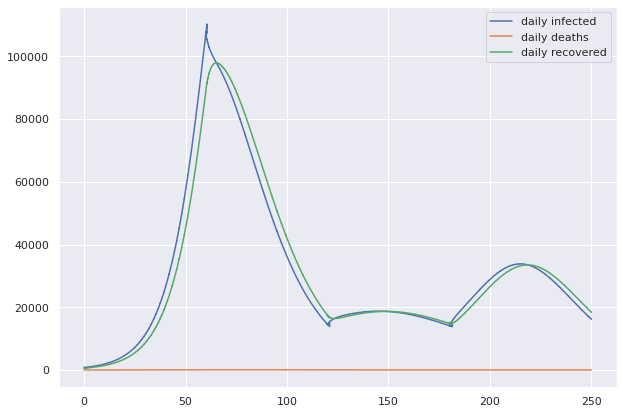

In [92]:
plt.figure(figsize=(10, 7))
plt.plot(history.new_infected, label='daily infected')
plt.plot(history.new_dead, label='daily deaths')
plt.plot(history.new_recovered, label='daily recovered')
plt.legend()
plt.show()

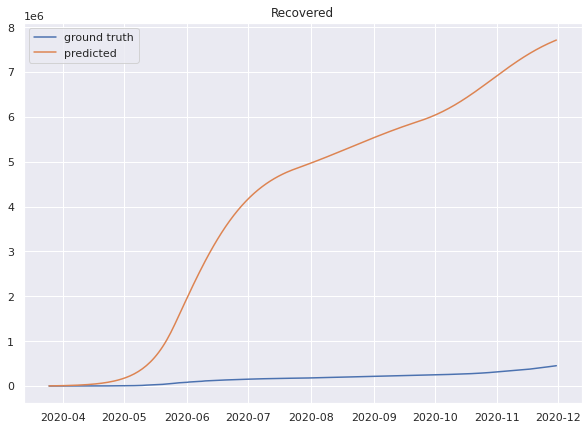

In [93]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

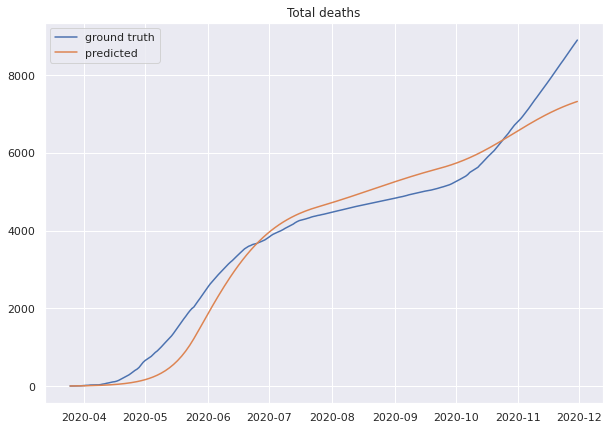

In [94]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

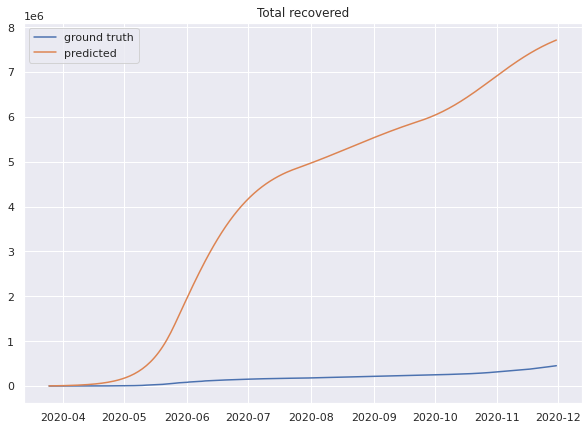

In [95]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

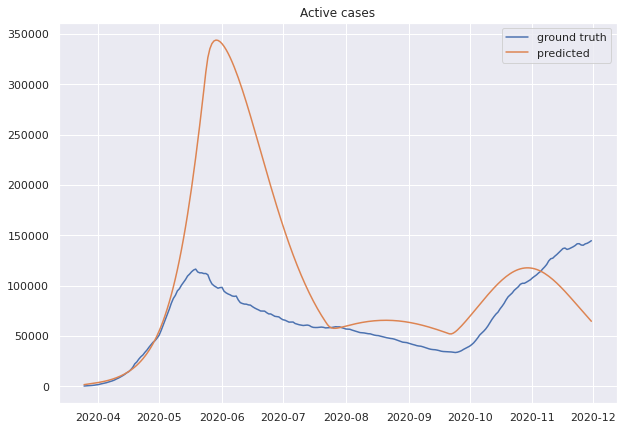

In [96]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

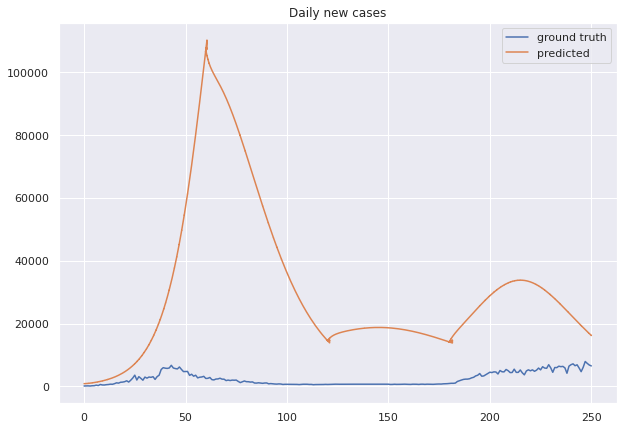

In [97]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_subset)), train_subset['infected_per_day'], label='ground truth')
plt.plot(history.new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

# Obtain forecast

In [98]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [99]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [100]:
test_initial_conds = (S[-1], E[-1], I[-1], R[-1], D[-1])

In [101]:
(test_S, test_E, test_I, test_R, test_D), history = model.predict(test_t, test_initial_conds)

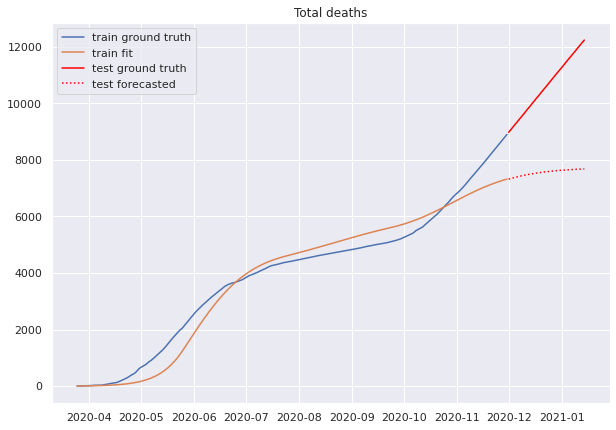

In [102]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

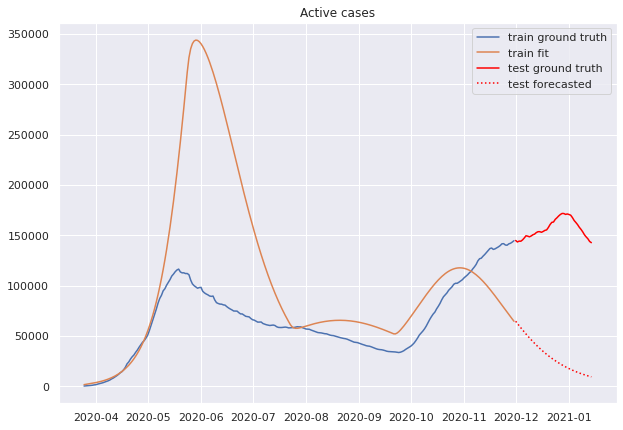

In [103]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

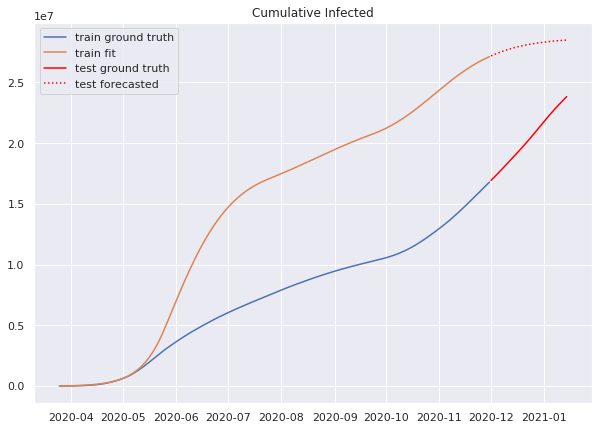

In [104]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

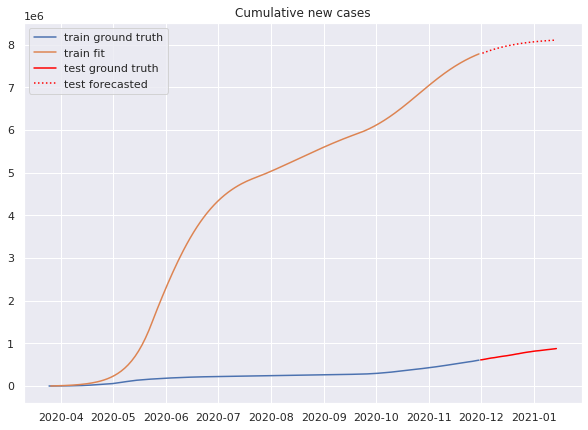

In [105]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# 1-day ahead evaluate

In [ ]:
eval_one_day_ahead(df, SEIR, CurveFitter, eval_period_start='2020-05-01', n_eval_points=50)

In [ ]:
# from sklearn.metrics import mean_absolute_error

In [ ]:
# n_eval_points = 10
# eval_period_start = '2020-05-01'
# eval_df = df[df.date >= eval_period_start].iloc[::len(df)//n_eval_points]
# pred_dates = []

# true_D, true_R = [], []

# baseline_pred_D, baseline_pred_R = [], []
# model_pred_D, model_pred_R = [], []

# for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
#     train_df = df.iloc[:row.Index]
    
#     pred_dates.append(row.date)
#     prev_day = train_df.iloc[-1]
#     pred_D = prev_day.total_dead
#     pred_R = prev_day.total_recovered
    
#     model = SEIR(verbose=False)
#     fitter = CurveFitter()
#     fitter.fit(model, train_df)
    
#     train_initial_conditions = fitter.get_initial_conditions(model, train_df)
#     train_t = np.arange(len(train_df))
#     (S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)
    
#     test_initial_conds = (S[-1], E[-1], I[-1], R[-1], D[-1])
    
#     (S, E, I, R, D), history = model.predict([train_t[-1], train_t[-1]+1], test_initial_conds)
    
    
#     model_pred_D.append(D[-1])
#     model_pred_R.append(R[-1])
#     baseline_pred_D.append(pred_D)
#     baseline_pred_R.append(pred_R)
#     true_D.append(row.total_dead)
#     true_R.append(row.total_recovered)

# baseline_D_mae = mean_absolute_error(true_D, baseline_pred_D)
# baseline_R_mae = mean_absolute_error(true_R, baseline_pred_R)

# model_D_mae = mean_absolute_error(true_D, model_pred_D)
# model_R_mae = mean_absolute_error(true_R, model_pred_R)

# print('Baseline D mae', round(baseline_D_mae, 3))
# print('Model D mae', round(model_D_mae, 3))

# print('Baseline R mae', round(baseline_R_mae, 3))
# print('Model R mae', round(model_R_mae, 3))

Baseline D mae 46.222
Model D mae 1613.62
Baseline R mae 2634.556
Model R mae 3266970.542
